# Post Seurat processing 
Now that I validated the dataset is the same dataset, now i need to process the data so that it goes well into AA 

This includes identifying any major skews in data that wouldnt be 

## Assessing skew

In [2]:
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import os

In [3]:
# Load AnnData
adata_path = r'C:/Users/DG1/Desktop/DALLAB/Experimenting/Data/Antibiotic resistance/BacDrop/Seurat/Output exp1/LIVE/1007/adata_prePCA_lognorm.h5ad'
assert os.path.exists(adata_path), f'File not found: {adata_path}'
adata = sc.read_h5ad(adata_path)
print(f'Loaded AnnData with shape: {adata.shape}')

Loaded AnnData with shape: (19642, 4514)


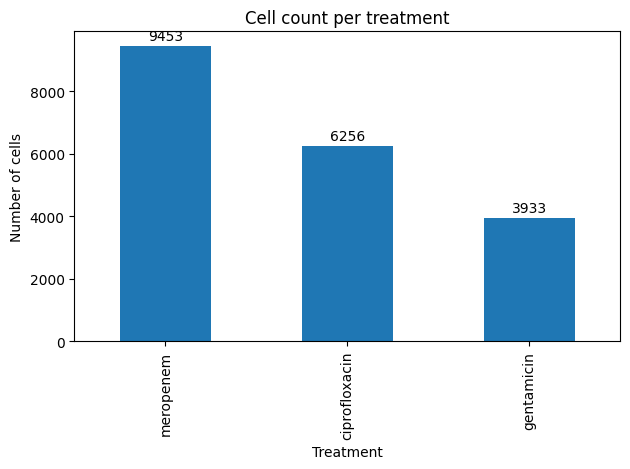

In [6]:
#Assessing number of cells per treatment

import matplotlib.pyplot as plt

counts = adata.obs["treatment"].value_counts()
ax = counts.plot(kind='bar')
plt.ylabel("Number of cells")
plt.xlabel("Treatment")
plt.title("Cell count per treatment")

# Add the count on top of each bar
for i, v in enumerate(counts.values):
    plt.text(i, v + max(counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

def plot_genes_expressed_per_cell_by_treatment(adata, treatment_col="treatment", min_expr=1e-9, bins=30):
    """
    For each treatment type, plot the distribution of the number of genes expressed per cell.
    Annotate the most frequent (mode) number of genes expressed per cell and its count.
    """
    X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    treatments = adata.obs[treatment_col]
    treatment_types = treatments.unique()
    
    for t in treatment_types:
        mask = (treatments == t).values if hasattr(treatments, 'values') else (treatments == t)
        X_sub = X[mask, :]
        # Count number of genes expressed per cell
        n_genes_expressed = (X_sub > min_expr).sum(axis=1)
        
        # Find the mode and its count
        mode_val, mode_count = mode(n_genes_expressed, keepdims=True)
        mode_val = int(mode_val[0])
        mode_count = int(mode_count[0])
        
        plt.figure(figsize=(7, 4))
        counts, bin_edges, patches = plt.hist(n_genes_expressed, bins=bins, color='skyblue', edgecolor='k')
        plt.title(f"Treatment: {t}\nGenes Expressed per Cell")
        plt.xlabel("Number of genes expressed per cell")
        plt.ylabel("Number of cells")
        
        # Annotate the mode
        plt.annotate(
            f"Mode: {mode_val}\nCount: {mode_count}",
            xy=(mode_val, mode_count),
            xytext=(mode_val, mode_count + max(counts)*0.05),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            ha='center', fontsize=10, color='black'
        )
        plt.tight_layout()
        plt.show()

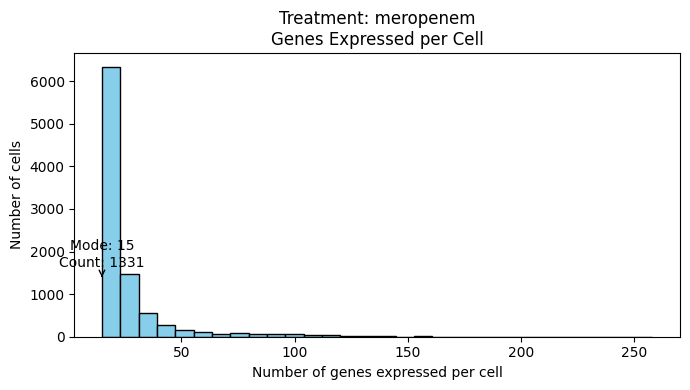

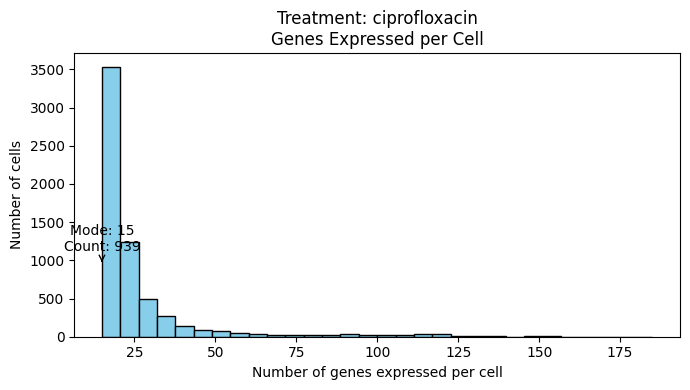

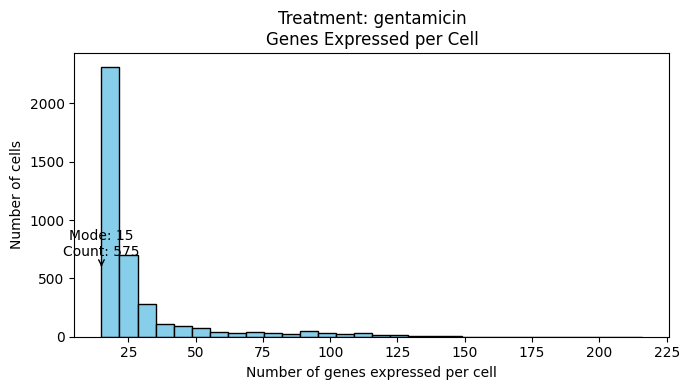

In [15]:
plot_genes_expressed_per_cell_by_treatment(adata, treatment_col="treatment")

## Addressing skew 


First by removing cells from mero and cipro samples until the numer of cells and their distribution across # of genes expressed matchges genta (i.e. they wuill have the same distribution). Random downsampling of more common classes to match least common class

In [ ]:
import numpy as np
import scanpy as sc
import pandas as pd

treatment_col = "treatment"
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
n_genes_expressed = (X > 0).sum(axis=1)
adata.obs["n_genes_expressed"] = n_genes_expressed

# Get all treatment types and all bins
treatment_types = adata.obs[treatment_col].unique()
all_bins = np.unique(adata.obs["n_genes_expressed"])

balanced_indices = []

for n_genes in all_bins:
    # For each bin, find the minimum number of cells across all treatments
    bin_counts = []
    bin_indices_per_treatment = []
    for treatment in treatment_types:
        mask = (adata.obs[treatment_col] == treatment) & (adata.obs["n_genes_expressed"] == n_genes)
        idx = adata.obs[mask].index.tolist()
        bin_counts.append(len(idx))
        bin_indices_per_treatment.append(idx)
    min_count = min(bin_counts)
    if min_count == 0:
        continue  # skip bins not present in all treatments
    # Sample min_count cells from each treatment for this bin
    for idx in bin_indices_per_treatment:
        sampled = np.random.choice(idx, min_count, replace=False) #random downsa
        balanced_indices.extend(sampled)

adata_balanced = adata[balanced_indices].copy()
sc.write("adata_balanced_gentamicin_distribution_min_per_bin.h5ad", adata_balanced)
print(f"Saved balanced AnnData with {adata_balanced.shape[0]} cells and {adata_balanced.shape[1]} genes.")

Saved balanced AnnData with 11493 cells and 4514 genes.


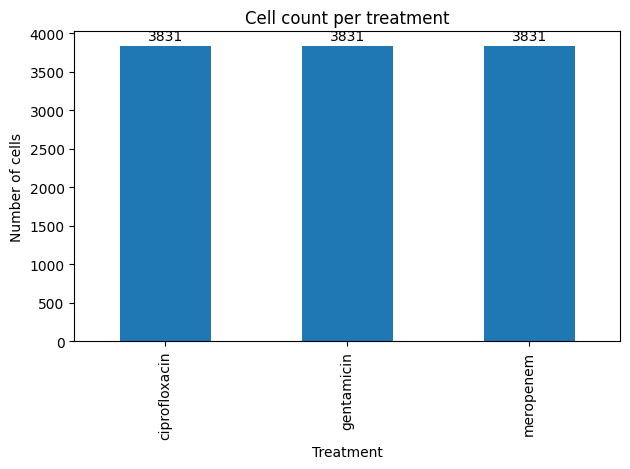

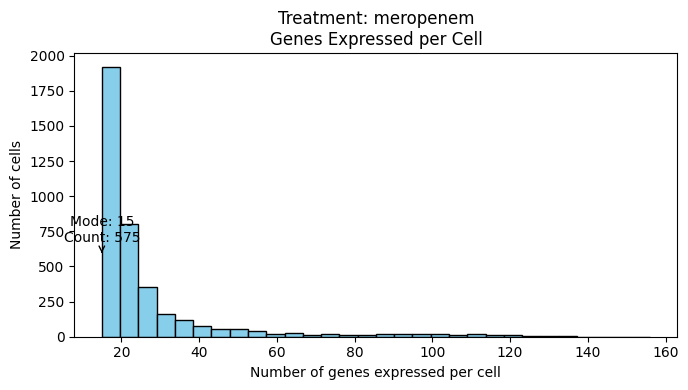

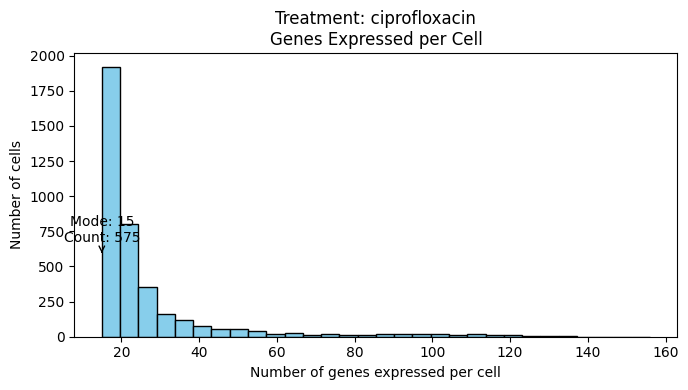

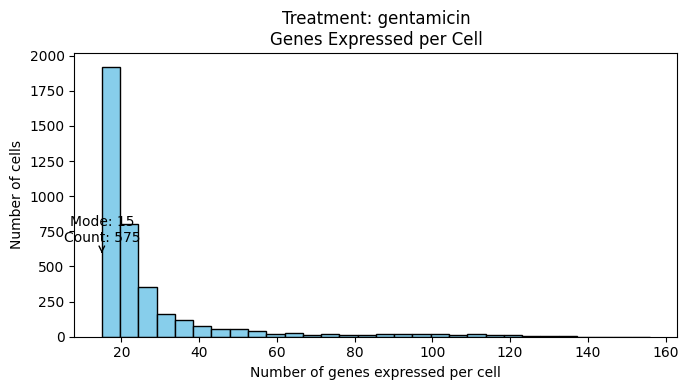

In [12]:
#checking distribution of adata_balanced

import matplotlib.pyplot as plt

counts = adata_balanced.obs["treatment"].value_counts()
ax = counts.plot(kind='bar')
plt.ylabel("Number of cells")
plt.xlabel("Treatment")
plt.title("Cell count per treatment")

# Add the count on top of each bar
for i, v in enumerate(counts.values):
    plt.text(i, v + max(counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


#plotting distribution of n_genes_expressed across treatments
plot_genes_expressed_per_cell_by_treatment(adata_balanced, treatment_col="treatment")

## Creating scrambled data for stat sig check
Scrambling data in original gene space independently along gene dimensions to break up any biolgoical structure. Feeds into post processing pipeline.

In [2]:
import numpy as np
import scanpy as sc

In [7]:
#generate random latent space to calculate null t-ratios

# Try to load the file, but if it doesn't exist, use the in-memory adata_balanced from previous steps
import os

h5ad_path = r'C:\Users\DG1\Desktop\DALLAB\Experimenting\Data\Antibiotic resistance\BacDrop\further processing\adata_balanced_gentamicin_distribution_min_per_bin.h5ad'

if os.path.exists(h5ad_path):
    adata_balanced = sc.read_h5ad(h5ad_path)
    print(f"Loaded adata_balanced from {h5ad_path}")
else:
    print(f"File not found: {h5ad_path}. Using adata_balanced from previous steps (if available).")
    # adata_balanced should already be defined earlier in the notebook



Loaded adata_balanced from C:\Users\DG1\Desktop\DALLAB\Experimenting\Data\Antibiotic resistance\BacDrop\further processing\adata_balanced_gentamicin_distribution_min_per_bin.h5ad


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 64.

In [ ]:
# Get the gene expression matrix as a numpy array
# If adata_balanced.X is sparse, convert to dense
if hasattr(adata_balanced.X, "toarray"):
    X = adata_balanced.X.toarray()
else:
    X = np.array(adata_balanced.X)

# Randomly permute each gene (column) independently
adata_balanced_rand = np.empty_like(X)
for i in range(X.shape[1]):
    adata_balanced_rand[:, i] = np.random.permutation(X[:, i])

# create a new AnnData object with the scrambled data:
import anndata
adata_balanced_rand_adata = anndata.AnnData(
    adata_balanced_rand,
    obs=adata_balanced.obs.copy(),
    var=adata_balanced.var.copy()
)

Are the original and randomised matrices identical? False


C:\Users\DG1\AppData\Local\Temp\ipykernel_36132\192433862.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(top5_orig_names, rotation=90)
C:\Users\DG1\AppData\Local\Temp\ipykernel_36132\192433862.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(top5_rand_names, rotation=90)


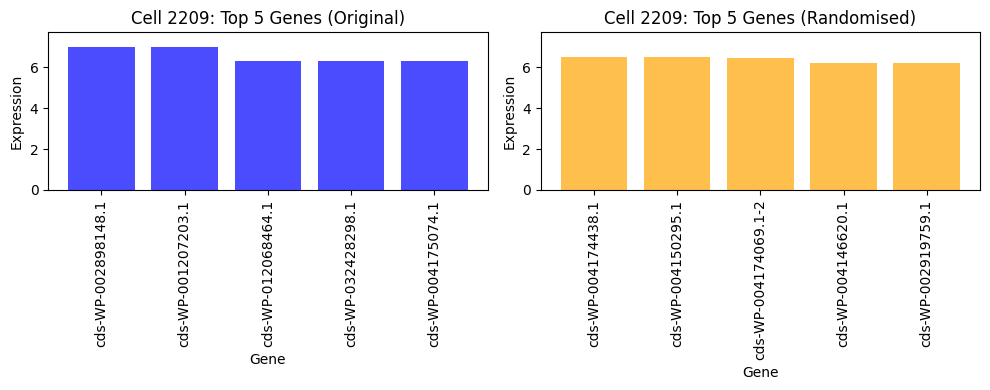

C:\Users\DG1\AppData\Local\Temp\ipykernel_36132\192433862.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(top5_orig_names, rotation=90)
C:\Users\DG1\AppData\Local\Temp\ipykernel_36132\192433862.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(top5_rand_names, rotation=90)


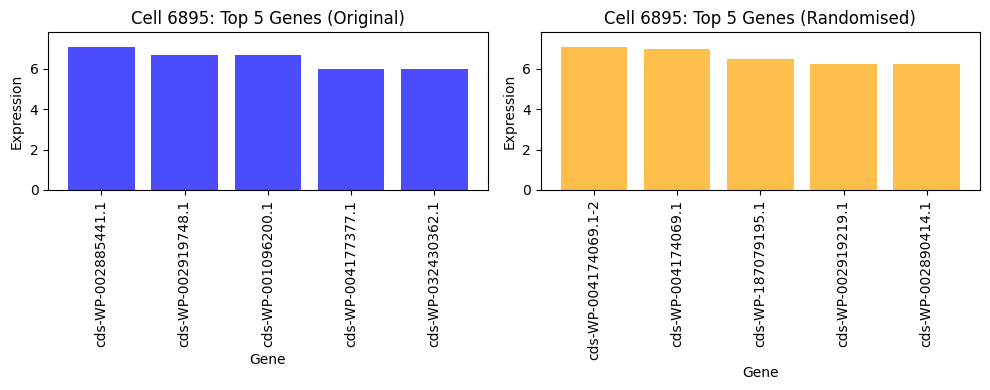

C:\Users\DG1\AppData\Local\Temp\ipykernel_36132\192433862.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(top5_orig_names, rotation=90)
C:\Users\DG1\AppData\Local\Temp\ipykernel_36132\192433862.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(top5_rand_names, rotation=90)


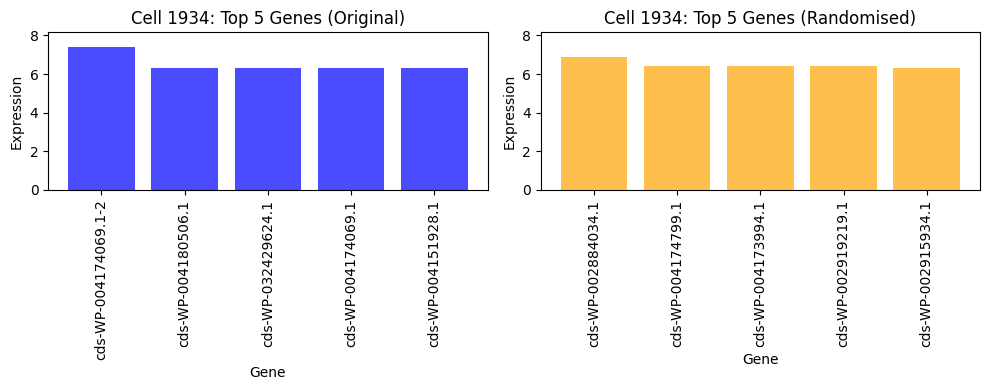

In [16]:
# Do the plots show the original and randomised data are identical?

# 1. Check if the matrices are identical (should be False after permutation)
identical = np.array_equal(X, adata_balanced_rand)
print(f"Are the original and randomised matrices identical? {identical}")

# Check the top 5 genes expressed for random cells: original vs randomised

import matplotlib.pyplot as plt
# Select 5 random cells (rows) from the dataset
num_cells = X.shape[0]
random_cell_indices = np.random.choice(num_cells, size=3, replace=False)

# For each selected cell, get the top 5 expressed genes in original and randomised data
for idx, cell_idx in enumerate(random_cell_indices):
    original_expr = X[cell_idx, :]
    randomised_expr = adata_balanced_rand[cell_idx, :]
    
    # Top 5 genes in this cell (original)
    top5_orig_idx = np.argsort(original_expr)[::-1][:5]
    top5_orig_names = gene_names[top5_orig_idx]
    top5_orig_vals = original_expr[top5_orig_idx]
    
    # Top 5 genes in this cell (randomised)
    top5_rand_idx = np.argsort(randomised_expr)[::-1][:5]
    top5_rand_names = gene_names[top5_rand_idx]
    top5_rand_vals = randomised_expr[top5_rand_idx]
    
    # Visualise comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(top5_orig_names, top5_orig_vals, color='blue', alpha=0.7)
    axes[0].set_title(f'Cell {cell_idx}: Top 5 Genes (Original)')
    axes[0].set_ylabel('Expression')
    axes[0].set_xlabel('Gene')
    axes[0].set_ylim(0, max(top5_orig_vals.max(), top5_rand_vals.max()) * 1.1)
    axes[0].set_xticklabels(top5_orig_names, rotation=90)

    axes[1].bar(top5_rand_names, top5_rand_vals, color='orange', alpha=0.7)
    axes[1].set_title(f'Cell {cell_idx}: Top 5 Genes (Randomised)')
    axes[1].set_ylabel('Expression')
    axes[1].set_xlabel('Gene')
    axes[1].set_ylim(0, max(top5_orig_vals.max(), top5_rand_vals.max()) * 1.1)
    axes[1].set_xticklabels(top5_rand_names, rotation=90)

    plt.tight_layout()
    plt.show()


